In [1]:
import glob
import cv2
import random
import re
import matplotlib.pyplot as plt
import numpy as np

In [2]:
images=glob.glob("data\*.jpg")
iimages=sorted(images, key=lambda s:int(re.search(r'\d+',s).group()))

In [3]:
im0=cv2.imread(iimages[191])
im1=cv2.imread(iimages[192])
im2=cv2.imread(iimages[193])

In [4]:
sift=cv2.SIFT_create(5000)
k1,d1= sift.detectAndCompute(im1,None)
k2,d2= sift.detectAndCompute(im2,None)

matcher= cv2.BFMatcher()
matches= matcher.knnMatch(d1,d2,k=2)
distances=[]
pts=[]
good=[]
for m,n in matches:
    if m.distance<0.75*n.distance:
        q=m.queryIdx
        t=m.trainIdx
        pos1=np.round(k1[q].pt).astype(int)
        pos2=np.round(k2[t].pt).astype(int)
        pts.append((pos1,pos2))
        dist=np.sqrt((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)
        distances.append(dist)
        good.append(m)
moy_dist=np.mean(distances)
pts=np.array(pts)
print(len(good))
print(moy_dist)

382
630.4788692240855


In [5]:
best=[good[i] for i,n in enumerate(distances) if abs(moy_dist-n)<0.25*moy_dist]
print(len(best))

323


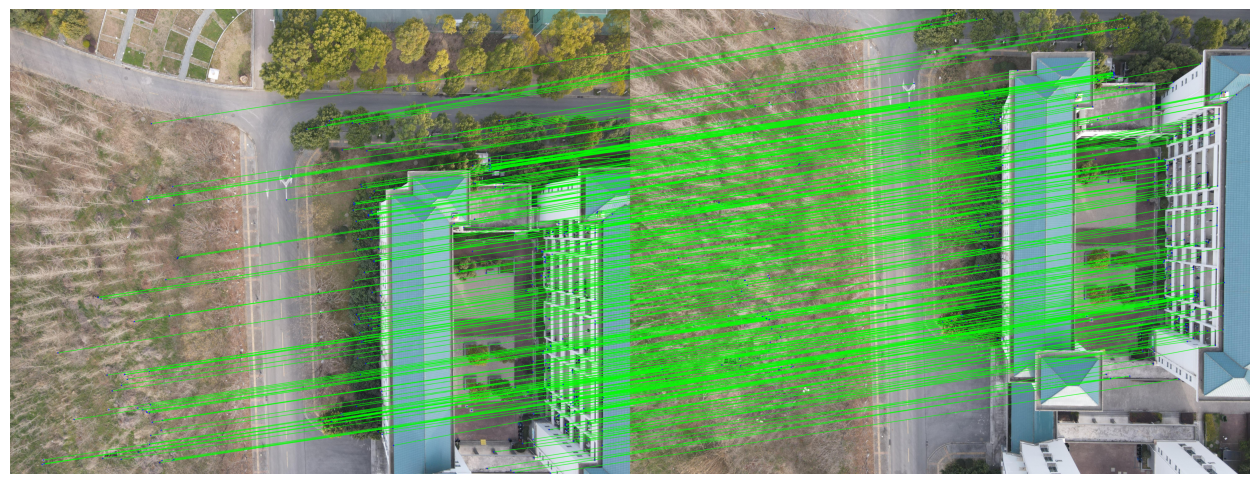

In [6]:
match_img = cv2.drawMatches(im1, k1, im2, k2, best, None,
                                    matchesMask=None,
                                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
h1, w1 = im1.shape[:2]
for i, m in enumerate(best):
    
    pt1 = tuple(np.round(k1[m.queryIdx].pt).astype(int))
    pt2 = tuple(np.round(k2[m.trainIdx].pt).astype(int))
    pt2_shifted = (int(pt2[0] + w1), int(pt2[1]))  # car concaténation horizontale

    cv2.line(match_img, pt1, pt2_shifted, (0,255,0), thickness=2, lineType=cv2.LINE_AA)
    cv2.circle(match_img, pt1, 4, (255,0,0), -1)
    cv2.circle(match_img, pt2_shifted, 4, (255,0,0), -1)

plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [6]:
src=np.float32([k1[m.queryIdx].pt for m in best]).reshape(-1,1,2)
dst=np.float32([k2[m.trainIdx].pt for m in best]).reshape(-1,1,2)

H, _= cv2.findHomography(src,dst,cv2.RANSAC, 5.0)

In [7]:
h1,w1=im1.shape[:2]
h2,w2=im2.shape[:2]

In [ ]:
pts_img1 = np.array([
    [0, 0],
    [w1, 0],
    [w1, h1],
    [0, h1]
], dtype=np.float32).reshape(-1, 1, 2)

pts_img2 = np.array([
    [0, 0],
    [w2, 0],
    [w2, h2],
    [0, h2]
], dtype=np.float32).reshape(-1, 1, 2)

proj_pts = cv2.perspectiveTransform(pts_img1, H)

In [9]:
all_pts = np.concatenate((proj_pts, pts_img2), axis=0)

In [10]:
[xmin, ymin] = np.floor(np.min(all_pts, axis=0)).astype(int)[0]
[xmax, ymax] = np.ceil(np.max(all_pts, axis=0)).astype(int)[0]

# Translation pour éviter les coordonnées négatives
tx, ty = -xmin, -ymin
T = np.array([
    [1, 0, tx],
    [0, 1, ty],
    [0, 0, 1]
])


In [11]:
offset = np.array([-xmin, -ymin], dtype=int)

In [81]:
#img1_position = offset

#translated_corners_img1 = (proj_pts + offset).astype(int)


In [49]:
[x_min, y_min] = np.int32(all_pts.min(axis=0).ravel())
[x_max, y_max] = np.int32(all_pts.max(axis=0).ravel())
translation_dist = [-x_min,-y_min]
H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

In [50]:
translation_dist

[10, 627]

In [13]:
pairs=[]
for m in best:
    x,y=k1[m.queryIdx].pt

    src_pt = np.array([[x, y]], dtype=np.float32).reshape(1, 1, 2)
    new = cv2.perspectiveTransform(src_pt, H_translation.dot(H)).reshape(2,)
    x,y=k2[m.trainIdx].pt
    old=np.array([x,y], dtype=np.float32)
    pairs.append(np.array([new,old]))
pairs=np.array(pairs)

In [ ]:
#dx, dy = np.mean([ (x2 - x1, y2 - y1) for (x1, y1), (x2, y2) in pairs ], axis=0)
# dx, dy = int(round(dx)), int(round(dy))

In [51]:
dx=x_min
dy=y_min

In [55]:
dy

-627

In [26]:
#
canvas_w=max(w1,w2)+abs(dx)
canvas_h=max(h1,h2)+abs(dy)

In [86]:
#
canvas = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)

In [87]:
#
canvas[-min(dy,0):h2-min(dy,0),-min(dx,0):w2-min(dx,0)]=im2

In [27]:
h1, w1 = im1.shape[:2]
mask1 = np.ones((h1, w1), dtype=np.uint8) * 255
mask_warped1 = cv2.warpPerspective(mask1, H_translation.dot(H), dsize=(x_max-x_min, y_max-y_min))

h2,w2= im2.shape[:2]
mask2=np.ones((h2,w2), dtype=np.uint8)*255
mask_warped2= cv2.warpPerspective(mask2, H_translation.astype(np.float32), dsize=(x_max-x_min, y_max-y_min))


In [28]:
output_img1 = cv2.warpPerspective(im1, H_translation.dot(H), (x_max-x_min, y_max-y_min))

In [29]:
output_img2 = cv2.warpPerspective(im2,H_translation.astype(np.float32),(x_max-x_min, y_max-y_min))

In [30]:
(x_max-x_min, y_max-y_min)

(4047, 3045)

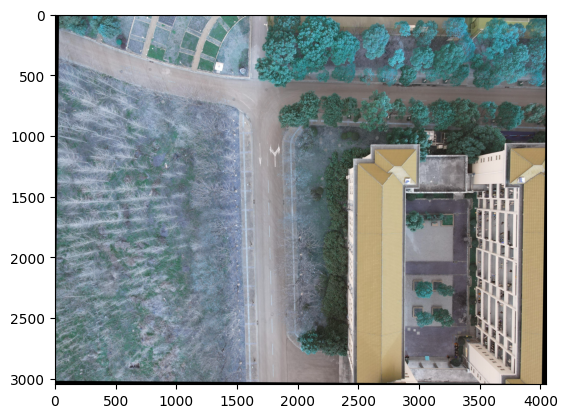

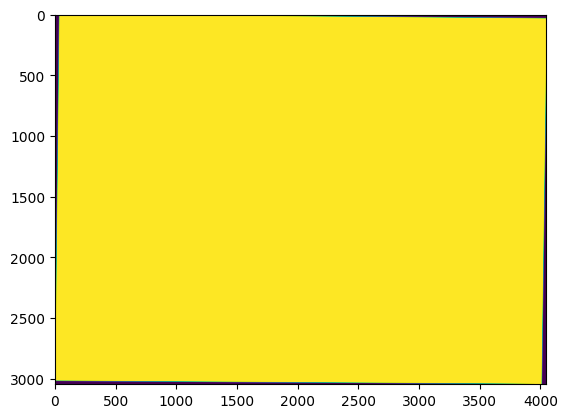

In [31]:
plt.imshow(output_img1)
plt.show()
plt.imshow(mask_warped1)
plt.show()

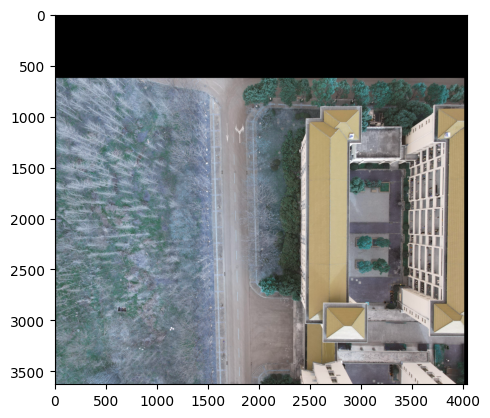

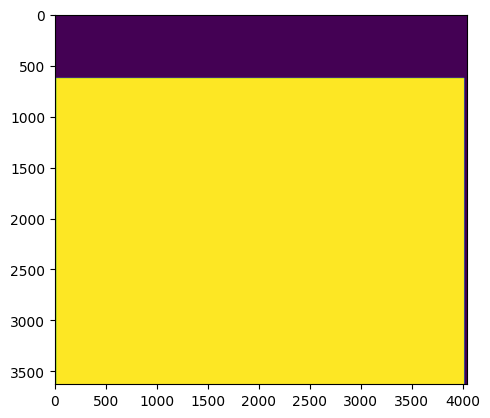

In [128]:
plt.imshow(output_img2)
plt.show()
plt.imshow(mask_warped2)
plt.show()

In [32]:
mask= np.bitwise_and(mask_warped1, mask_warped2)

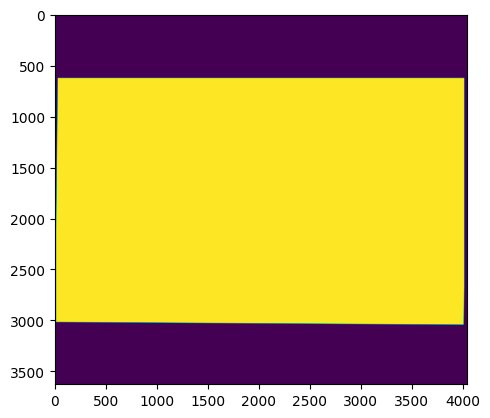

In [134]:
plt.imshow(mask)
plt.show()

In [33]:
cover2= cv2.bitwise_and(output_img2, output_img2, mask=mask)

In [34]:
cover1= cv2.bitwise_and(output_img1,output_img1,mask=mask)

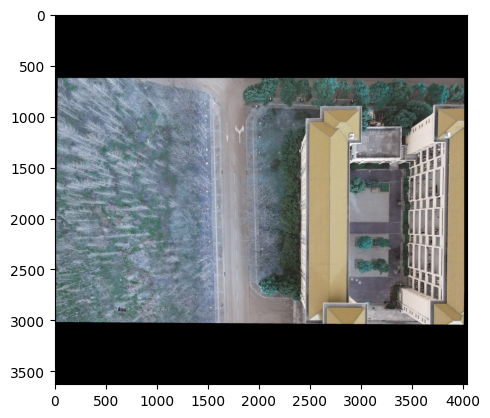

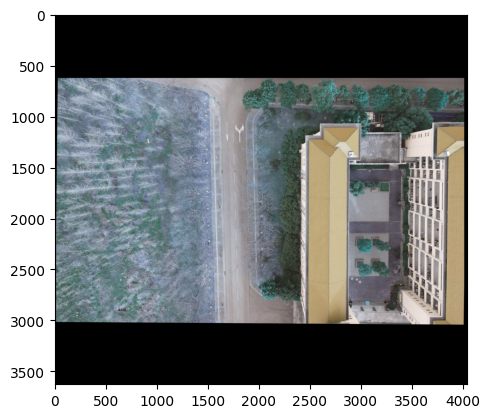

In [137]:
plt.imshow(cover2)
plt.show()
plt.imshow(cover1)
plt.show()

In [35]:
col1 = cv2.cvtColor(cover1, cv2.COLOR_BGR2LAB)
col2 = cv2.cvtColor(cover2, cv2.COLOR_BGR2LAB)
diff_lab = np.linalg.norm(col1.astype(np.float32) - col2.astype(np.float32), axis=2)

In [36]:
blur11 = cv2.GaussianBlur(col1, (5, 5), sigmaX=0.6)
blur12 = cv2.GaussianBlur(col1, (5, 5), sigmaX=1.0)
struct1 = cv2.absdiff(blur11, blur12)

blur21 = cv2.GaussianBlur(col2, (5, 5), sigmaX=0.6)
blur22 = cv2.GaussianBlur(col2, (5, 5), sigmaX=1.0)
struct2 = cv2.absdiff(blur21, blur22)

diff_struct = np.linalg.norm(struct1.astype(np.float32) - struct2.astype(np.float32), axis=2)


In [37]:
# Convertir en niveaux de gris
gray1 = cv2.cvtColor(cover1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(cover2, cv2.COLOR_BGR2GRAY)

# Créer le détecteur de segments de ligne
lsd = cv2.createLineSegmentDetector(0)

# Détection des lignes
lines1 = lsd.detect(gray1)[0]  # [0] contient les lignes détectées ou None
lines2 = lsd.detect(gray2)[0]

# Masques d'accumulation
mask_lines1 = np.zeros_like(gray1, dtype=np.uint8)
mask_lines2 = np.zeros_like(gray2, dtype=np.uint8)

if lines1 is not None:
    lsd.drawSegments(mask_lines1, lines1.astype(np.float32))

if lines2 is not None:
    lsd.drawSegments(mask_lines2, lines2.astype(np.float32))

# Calcul de la différence
diff_lines = cv2.absdiff(mask_lines1, mask_lines2).astype(np.float32)

In [38]:
E=diff_struct+diff_lab+diff_lines

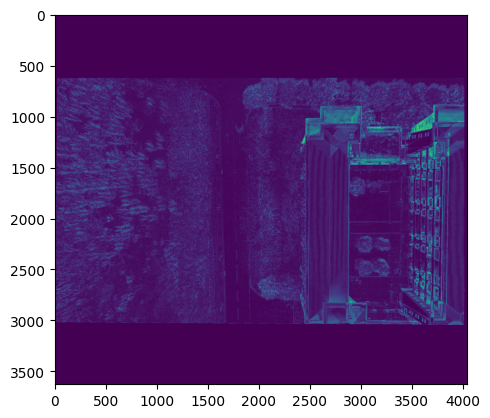

In [142]:
plt.imshow(E)
plt.show()

In [39]:
coords=np.column_stack(np.where(mask>0))

In [40]:
left=int(np.percentile(coords[:,0],25))
right=int(np.percentile(coords[:,0],75))

start=coords[np.where(coords[:,0]==left)[0][0]]
end=coords[np.where(coords[:,0]==right)[0][-1]]

In [146]:
print(start,end)

[1229   20] [2431 4009]


In [41]:
flat_E = E[mask > 0].flatten()
thresholds = np.unique(np.sort(flat_E))
low = 0
high = len(thresholds) - 1
best_R = None

In [42]:
from scipy.ndimage import label

In [43]:
while low <= high:
        mid = (low + high) // 2
        threshold = thresholds[mid]

        # Zone où E < seuil
        R = np.zeros_like(E, dtype=np.uint8)
        R[(E < threshold) & (mask > 0)] = 1

        # Trouver composantes connexes à 8 connexions
        labeled, num = label(R, structure=np.ones((3, 3), dtype=np.uint8))

        label_start = labeled[tuple(start)]
        label_end = labeled[tuple(end)]

        if label_start != 0 and label_start == label_end:
            # Ils sont connectés
            best_R = R.copy()
            high = mid - 1  # Chercher plus petit
        else:
            low = mid + 1

In [53]:
y_min=min(coords[:,0])
y_max=max(coords[:,0])
x_min=min(coords[:,1])
x_max=max(coords[:,1])

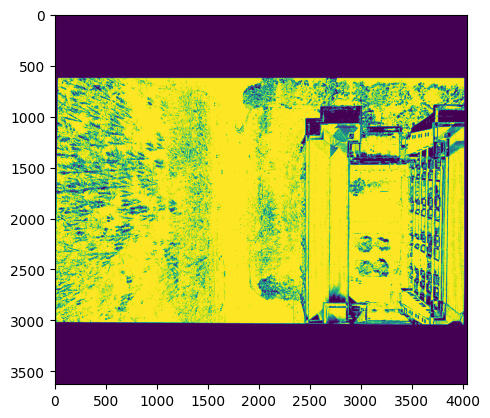

In [150]:
plt.imshow(best_R)
plt.show()


In [45]:
import heapq


#def find_optimal_seam_astar(E, R, start, end, diagonal=True):
"""
A* pathfinding sur une grille 8-connectée (ou 4) pour chercher un seam optimal.

Paramètres :
    E : matrice de coûts (float32)
    R : masque binaire de la search region (uint8)
    start, end : tuples (x, y)
    diagonal : True pour 8-connexité, False pour 4-connexité

Retour :
    path : liste de (x, y) représentant la couture optimale
"""

h, w = E.shape
visited = np.zeros((h, w), dtype=bool)
came_from = np.full((h, w, 2), -1, dtype=int)
cost_so_far = np.full((h, w), np.inf, dtype=np.float32)

sy, sx = start
ey, ex = end
diagonal=True
cost_so_far[sy, sx] = E[sy, sx]

# distance euclidienne vers le but
def heuristic(x, y):
    return np.sqrt((x - ex)**2 + (y - ey)**2)

# directions 4 ou 8
if diagonal:
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
                    (-1, -1), (-1, 1), (1, -1), (1, 1)]
else:
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# file de priorité avec (f, g, x, y)
open_set = [(E[sy, sx] + heuristic(sx, sy), E[sy, sx], sx, sy)]

while open_set:
    _, g, x, y = heapq.heappop(open_set)

    if visited[y, x]:
        continue
    visited[y, x] = True

    if (x, y) == (ex, ey):
        break  # but atteint

    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if x_min <= nx <= x_max and y_min <= ny <= y_max and best_R[ny, nx]:
            new_cost = g + E[ny, nx]
            if new_cost < cost_so_far[ny, nx]:
                cost_so_far[ny, nx] = new_cost
                came_from[ny, nx] = [y, x]
                f = new_cost + heuristic(nx, ny)
                heapq.heappush(open_set, (f, new_cost, nx, ny))

# reconstruction du chemin
path = []
x, y = ex, ey
while x != -1 and y != -1:
    path.append((y, x))
    y_prev, x_prev = came_from[y, x]
    x, y = x_prev, y_prev

path.reverse()
#return path


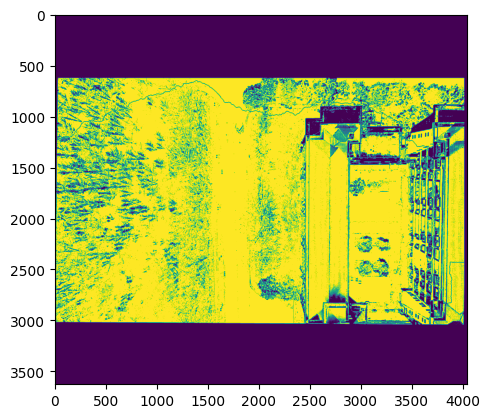

In [ ]:
vis=best_R.copy()
for y,x in path:
    cv2.circle(vis, (x,y), 1, (0,255,0),-1)
plt.imshow(vis)
plt.show()

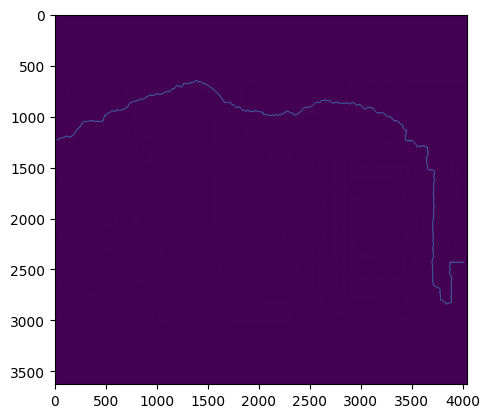

In [166]:
vis=best_R.copy()
for y,x in path:
    cv2.circle(vis, (x,y), 1, (255,0,0),-1)
plt.imshow(vis)
plt.show()

In [46]:
mask=np.zeros(output_img1.shape[:2])
for m in path:
    y=m[0]
    x=m[1]
    mask[:y,x]=1
mask[:start[0],:start[1]]=1
mask[:end[0],end[1]:]=1

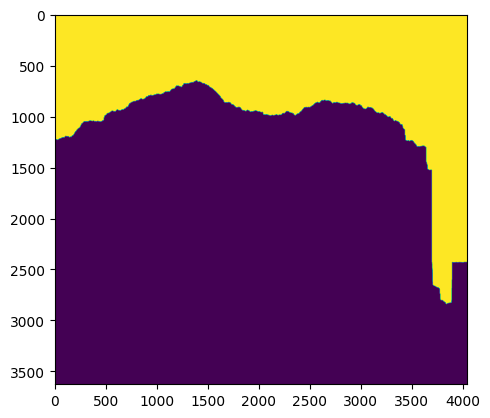

In [201]:
plt.imshow(mask*255)
plt.show()

In [47]:


# Appliquer le masque pour créer l'image fusionnée
result = np.zeros_like(output_img2)
for c in range(3):
    result[:, :, c] = output_img1[:, :, c] * mask + output_img2[:, :, c] * (1 - mask)


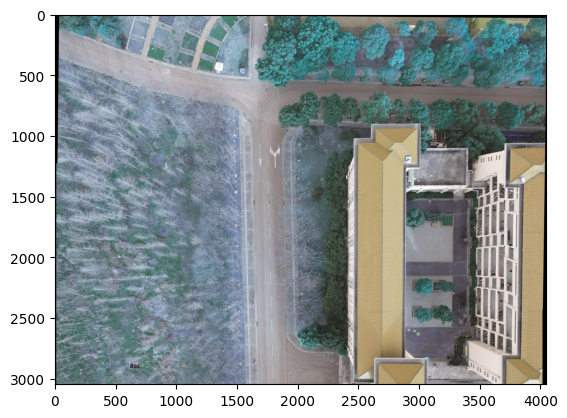

In [48]:
plt.imshow(result)
plt.show()

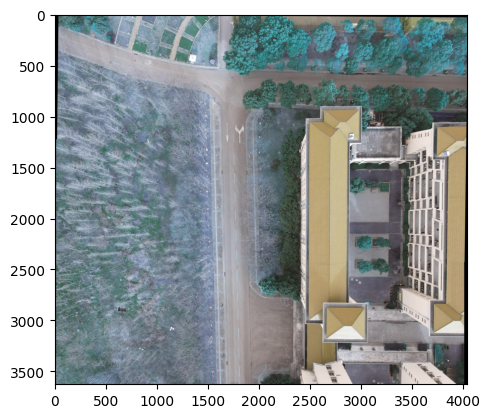

In [203]:
plt.imshow(result)
plt.show()